# Tugas Besar 2 Inteligensi Buatan

<b>Kelompok ChiMonke</b>
|No|        Nama          |    NIM    |
|--|----------------------|-----------|
|1.|Michael Jonathan Halim| 13521124  |
|2.|Chiquita Ahsanunnisa  | 13521129  |
|3.|Enrique Alifio Ditya  |	13521142  |
|4.|Rava Maulana		  | 13521149  |

## Import Libraries

In [1222]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Constants

In [1223]:
from matplotlib.colors import LinearSegmentedColormap

TARGET = "price_range"
RANDOM_STATE = 42

THEME = 'orangered'
CMAP_COLOUR = LinearSegmentedColormap.from_list(THEME, ['#FFECEC',THEME])

NUM_FEAT = ["battery_power", "clock_speed", "fc", "int_memory", "m_dep", "mobile_wt", "n_cores", "pc", "px_height", "px_width", "ram", "sc_h", "sc_w", "talk_time"]
CAT_FEAT = ["blue", "dual_sim", "four_g", "three_g", "touch_screen", "wifi"]

## Import Dataset

In [1224]:
train_set = pd.read_csv("../data/data_train.csv")
train_set.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,804,1,0.8,1,12,1,41,0.9,89,1,...,709,818,2027,11,5,11,1,0,0,1
1,1042,0,2.2,0,15,1,11,0.6,139,5,...,68,1018,2826,18,0,2,1,0,0,2
2,1481,1,2.0,1,0,0,35,0.5,105,3,...,249,522,2635,17,16,4,1,0,1,2
3,1104,0,1.7,0,1,1,60,0.4,199,2,...,653,1413,1229,6,0,3,1,1,1,0
4,652,0,0.5,1,1,0,58,0.6,142,3,...,464,781,565,18,12,9,0,0,1,0


In [1225]:
val_set = pd.read_csv("../data/data_validation.csv")
val_set.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
2,769,1,2.9,1,0,0,9,0.1,182,5,...,248,874,3946,5,2,7,0,0,0,3
3,775,0,1.0,0,3,0,46,0.7,159,2,...,862,1864,568,17,15,11,1,1,1,0
4,595,0,0.9,1,7,1,23,0.1,121,3,...,441,810,3752,10,2,18,1,1,0,3


# Why do we need to split the data into training and validation sets?

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. Later on, we will also implement cross validation to further evaluate our model.

# Preprocessing

The following are the steps taken to preprocess the data before feeding it into a classifier:

1. Feature Engineering
2. Feature Dropping
3. Encoding Categorical Columns
4. Resampling

The preprocessing is done with a pipeline approach by designing dedicated classes and/or functions for each steps and automating it by feeding the data to a predefined pipeline.

## Feature Creation

This step includes creating and combining features that may improve the performance of the classifier.

In [1226]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create class to create new features
class FeatureCreator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.fitted_cols = X.columns
        return self
    
    def transform(self, X):
        # Get the newly created columns
        new_columns = list(filter(lambda x: x not in self.fitted_cols, X.columns))

        # Compute correlation with TARGET feature for the newly created columns
        if TARGET in X.columns:
            target_corr = X[new_columns].apply(lambda col: col.corr(X[TARGET]))

            # Print correlation results for the newly created columns
            for col, corr in target_corr.items():
                print(f"Feature {col} created with {corr} correlation to target")
            
        print()
        
        return X

## Feature Dropping

This step is to remove null and previously combined columns from the dataset.

In [1227]:
# Create feature dropper class
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=CAT_FEAT)

## Feature Scaling

In [1228]:
def get_non_binary_numeric_features(data):
    # Get the data types of all columns
    column_data_types = data.dtypes

    # Find columns with numeric data types
    numeric_columns = column_data_types[column_data_types.apply(lambda x: pd.api.types.is_numeric_dtype(x))].index

    # Filter out binary features (those with only 2 unique values)
    non_binary_numeric_features = []
    for col in numeric_columns:
        if col == TARGET:
            continue
        
        unique_values = data[col].nunique()
        if unique_values > 2:
            non_binary_numeric_features.append(col)

    return non_binary_numeric_features

In [1229]:
from sklearn.preprocessing import StandardScaler

class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = None
        self.numerical_cols = None
    
    def fit(self, X, y=None):
        self.numerical_cols = get_non_binary_numeric_features(X)

        self.scaler = StandardScaler().fit(X[self.numerical_cols])
        return self
    
    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.numerical_cols] = self.scaler.transform(X[self.numerical_cols])
        
        return X_scaled

## PCA

In [1230]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

class CustomPCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2):
        self.pca = None
        self.numerical_cols = None
        self.n_components = n_components

    def fit(self, X, y=None):
        self.numerical_cols = get_non_binary_numeric_features(X)
        self.pca = PCA(n_components=self.n_components).fit(X[self.numerical_cols])
        return self
    
    def transform(self, X):
        X_pca = X.copy()
        principal_components = self.pca.transform(X[self.numerical_cols])
        
        for i in range(self.n_components):
            X_pca[f'PC{i + 1}'] = principal_components[:, i]

        X_pca = X_pca.drop(columns=self.numerical_cols)

        return X_pca

## Feature Imputer

In [1231]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class FeatureImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean'):
        self.imputer = None
        self.numerical_cols = None
        self.strategy = strategy

    def fit(self, X, y=None):
        self.numerical_cols = get_non_binary_numeric_features(X)
        self.imputer = SimpleImputer(strategy=self.strategy)

        self.imputer.fit(X[self.numerical_cols])
        return self
    
    def transform(self, X):
        X_imputed = X.copy()
        X_imputed[self.numerical_cols] = self.imputer.transform(X[self.numerical_cols])

        X_imputed['px_height'] = np.maximum(X_imputed['px_height'], 217)
        X_imputed['sc_w'] = np.maximum(X_imputed['sc_w'], 2.5)

        return X_imputed

# Prepare Training and Validation set

All of the preprocessing steps will be compiled in this section.

## Fitting the Pipeline

We will pass down the training and validation set through a pipeline that performs the preprocessing steps defined before.

In [1232]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("featurecreator", FeatureCreator()),
                     ("dropper", FeatureDropper()),
                     ("imputer", FeatureImputer()),
                     ("pca", CustomPCA(n_components=10))])

In [1233]:
train_set = pipeline.fit_transform(train_set)
val_set = pipeline.transform(val_set)

In [1234]:
train_set.head()

,price_range,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1,-81.681172,-261.977404,-438.196764,-341.883575,-51.286526,7.172498,6.511474,-0.427766,-2.031461,-4.951241
1,2,718.808168,-475.134580,-210.500676,146.921308,1.085919,-20.363567,10.252116,9.403710,0.568935,-3.035439
2,2,519.706604,-823.164356,220.578398,-212.993699,-35.454733,2.018637,-11.440728,8.888005,8.358935,-2.959886
3,0,-875.153410,119.739950,-136.306685,124.507259,58.039249,30.184567,1.561229,6.183566,-8.009064,3.474913
4,0,-1542.592855,-443.961339,-608.688256,-181.637111,-0.986581,26.654930,-8.516465,2.911266,7.661617,-1.512351


In [1235]:
print(len(train_set))

1400


In [1236]:
val_set.head()

,price_range,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1,440.195602,-653.902445,-415.995209,-36.456272,49.326920,-22.990480,-9.272399,-8.188621,0.173259,-1.893778
1,2,504.273083,772.443496,-641.307840,-122.259778,7.571204,9.079610,-3.986966,0.910958,-4.165465,0.623798
2,3,1838.760327,-554.224405,-477.332304,10.057157,45.744292,-21.046579,-10.462033,2.333725,-8.141412,-1.249171
3,0,-1529.525160,604.988485,-454.627238,289.680185,18.550781,15.363902,5.114080,1.528456,9.213071,2.338798
4,3,1644.893610,-458.028794,-646.293492,-173.900565,-15.993853,-9.476323,7.158558,-7.726173,-2.723379,1.638583


In [1237]:
print(len(val_set))

600


In [1238]:
null_test = val_set.columns[val_set.isnull().any()]
print(val_set[null_test].isnull().sum())

Series([], dtype: float64)


## Matching the Train and Validation Columns

Columns need to be matched between the train and validation set as there may be columns that exists in the validation set but not in the training set, and vice versa.

In [1239]:
def match_columns(train, test):
    # Get list of columns in training set
    train_cols = train.columns.tolist()
    
    # Get list of columns in test set
    test_cols = test.columns.tolist()
    
    # Remove any columns in test set that aren't in training set
    for col in test_cols:
        if col not in train_cols:
            test = test.drop(col, axis=1)
    
    # Add any missing columns to test set and fill with 0
    for col in train_cols:
        if col not in test_cols:
            test[col] = 0
    
    # Reorder columns in test set to match training set
    test = test[train_cols]
    
    # Return modified test set
    return test

In [1240]:
# Match the columns
val_set = match_columns(train_set, val_set)

In [1241]:
train_set.head()

,price_range,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1,-81.681172,-261.977404,-438.196764,-341.883575,-51.286526,7.172498,6.511474,-0.427766,-2.031461,-4.951241
1,2,718.808168,-475.134580,-210.500676,146.921308,1.085919,-20.363567,10.252116,9.403710,0.568935,-3.035439
2,2,519.706604,-823.164356,220.578398,-212.993699,-35.454733,2.018637,-11.440728,8.888005,8.358935,-2.959886
3,0,-875.153410,119.739950,-136.306685,124.507259,58.039249,30.184567,1.561229,6.183566,-8.009064,3.474913
4,0,-1542.592855,-443.961339,-608.688256,-181.637111,-0.986581,26.654930,-8.516465,2.911266,7.661617,-1.512351


In [1242]:
val_set.head()

,price_range,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1,440.195602,-653.902445,-415.995209,-36.456272,49.326920,-22.990480,-9.272399,-8.188621,0.173259,-1.893778
1,2,504.273083,772.443496,-641.307840,-122.259778,7.571204,9.079610,-3.986966,0.910958,-4.165465,0.623798
2,3,1838.760327,-554.224405,-477.332304,10.057157,45.744292,-21.046579,-10.462033,2.333725,-8.141412,-1.249171
3,0,-1529.525160,604.988485,-454.627238,289.680185,18.550781,15.363902,5.114080,1.528456,9.213071,2.338798
4,3,1644.893610,-458.028794,-646.293492,-173.900565,-15.993853,-9.476323,7.158558,-7.726173,-2.723379,1.638583


Below, we examine each column's correlation to the target variable after preprocessing.

In [1243]:
train_set.corr()[TARGET].sort_values(ascending=False)

price_range    1.000000
PC1            0.918360
PC3            0.207560
PC2            0.177124
PC6            0.011358
PC8            0.004304
PC9            0.002092
PC10           0.001351
PC7            0.001145
PC4           -0.009563
PC5           -0.031096
Name: price_range, dtype: float64

# Implement Classifiers


In this section, we will implement classifiers to train on.

In [1244]:
from Models.neighbors import KNN
from Models.bayes import NaiveBayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

knn = KNN(k=7)
nb = NaiveBayes()
knn_lib = KNeighborsClassifier(n_neighbors=7)
nb_lib = GaussianNB()

clfs = [knn, nb, knn_lib, nb_lib]

In [1245]:
# Split predictor and target variable
X_train = train_set.drop([TARGET], axis=1)
y_train = train_set[TARGET]

X_val = val_set.drop([TARGET], axis=1)
y_val = val_set[TARGET]

In [1246]:
for clf in clfs:
    clf.fit(X_train, y_train)

# Evaluation

In this section, we will evaluate the performance of our classifier on the training and validation set.

In [1247]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='macro'),
                                recall_score(y_test, y_pred, average='macro'),
                                f1_score(y_test, y_pred, average='macro')],
                          index=['Accuracy','Macro Precision','Macro Recall','Macro F1-score'],
                          columns = [model_name])
    
    result = (result * 100).round(5).astype(str) + '%'                            
    return result

In [1248]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name=None):
    '''
    This function provides a complete report of the model's performance including classification reports and confusion matrix
    '''
    
    if model_name is None:
        model_name = clf.__class__.__name__
    
    # Set font scale
    sns.set(font_scale=1.5)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print()
    print(f"\n\t  {model_name} EVALUATION REPORT")
    print("="*55)
    print("\n\t\t  Training Set Performance")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t\t  Validation Set Performance")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    print('\n')
    
    # Create figure and subplots 
    fig, ax1 = plt.subplots(1, 1, dpi=90, figsize=(12, 5))
    
    # Report desired results as a summary in the form of a table
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax1.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 4.2)
    table.set_fontsize(12)
    ax1.axis('tight')
    # Hide the axes
    ax1.axis('off')
    # set the title
    ax1.set_title('{} Performance Summary'.format(model_name), fontsize=18)
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color(THEME)
              
    plt.tight_layout()
    plt.show()

In [1249]:
X_val.dtypes

PC1     float64
PC2     float64
PC3     float64
PC4     float64
PC5     float64
PC6     float64
PC7     float64
PC8     float64
PC9     float64
PC10    float64
dtype: object



	  KNN EVALUATION REPORT

		  Training Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       358
           1       0.93      0.95      0.94       356
           2       0.91      0.92      0.92       345
           3       0.97      0.93      0.95       341

    accuracy                           0.94      1400
   macro avg       0.94      0.94      0.94      1400
weighted avg       0.94      0.94      0.94      1400


		  Validation Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       142
           1       0.91      0.88      0.90       144
           2       0.90      0.90      0.90       155
           3       0.97      0.94      0.95       159

    accuracy                           0.93       600
   macro avg       0.93      0.93     

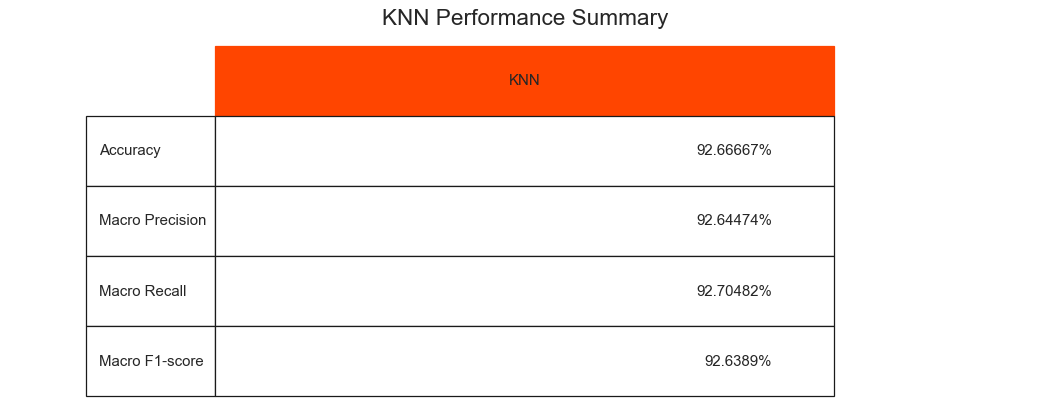



	  NaiveBayes EVALUATION REPORT

		  Training Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       358
           1       0.72      0.74      0.73       356
           2       0.70      0.68      0.69       345
           3       0.87      0.89      0.88       341

    accuracy                           0.80      1400
   macro avg       0.80      0.80      0.80      1400
weighted avg       0.80      0.80      0.80      1400


		  Validation Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       142
           1       0.64      0.63      0.64       144
           2       0.68      0.70      0.69       155
           3       0.91      0.89      0.90       159

    accuracy                           0.78       600
   macro avg       0.77      0.

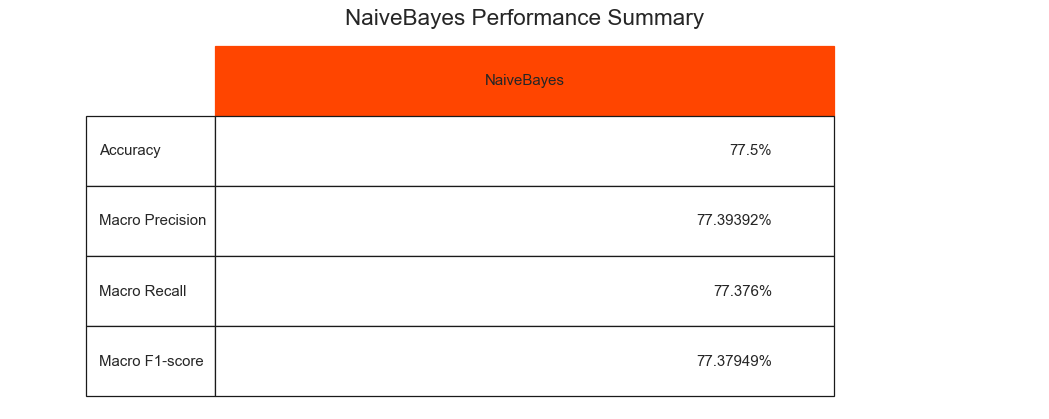



	  KNeighborsClassifier EVALUATION REPORT

		  Training Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       358
           1       0.93      0.95      0.94       356
           2       0.91      0.92      0.92       345
           3       0.97      0.93      0.95       341

    accuracy                           0.94      1400
   macro avg       0.94      0.94      0.94      1400
weighted avg       0.94      0.94      0.94      1400


		  Validation Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       142
           1       0.91      0.88      0.90       144
           2       0.90      0.90      0.90       155
           3       0.97      0.94      0.95       159

    accuracy                           0.93       600
   macro avg       0.

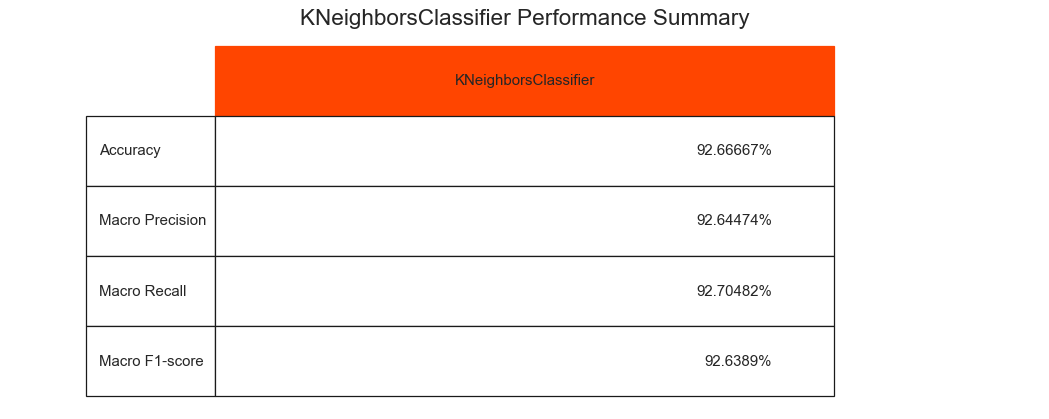



	  GaussianNB EVALUATION REPORT

		  Training Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       358
           1       0.72      0.74      0.73       356
           2       0.70      0.68      0.69       345
           3       0.87      0.89      0.88       341

    accuracy                           0.80      1400
   macro avg       0.80      0.80      0.80      1400
weighted avg       0.80      0.80      0.80      1400


		  Validation Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       142
           1       0.64      0.63      0.64       144
           2       0.68      0.70      0.69       155
           3       0.91      0.89      0.90       159

    accuracy                           0.78       600
   macro avg       0.77      0.

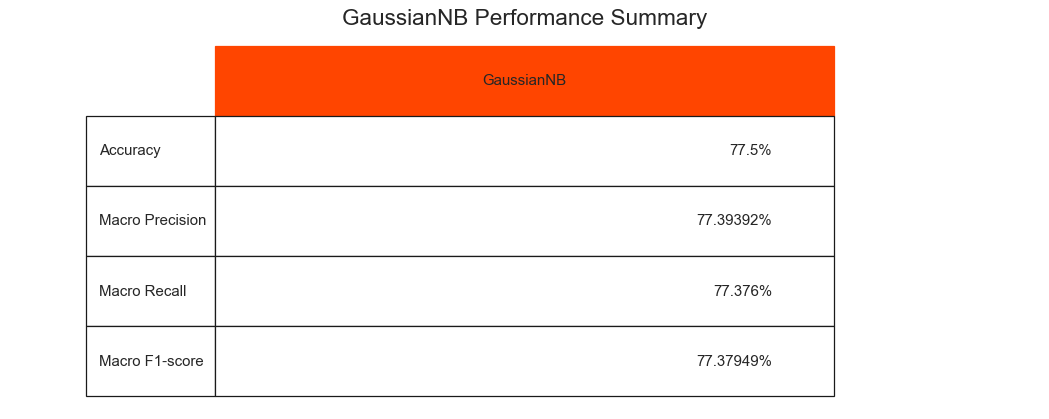

In [1250]:
for clf in clfs:
    model_evaluation(clf, X_train, X_val, y_train, y_val)

# Submission

In [1251]:
train = pd.read_csv("../data/data_initial_train.csv")
test = pd.read_csv("../data/test.csv")

In [1252]:
train

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,804,1,0.8,1,12,1,41,0.9,89,1,...,709,818,2027,11,5,11,1,0,0,1
1,1042,0,2.2,0,15,1,11,0.6,139,5,...,68,1018,2826,18,0,2,1,0,0,2
2,1481,1,2.0,1,0,0,35,0.5,105,3,...,249,522,2635,17,16,4,1,0,1,2
3,1104,0,1.7,0,1,1,60,0.4,199,2,...,653,1413,1229,6,0,3,1,1,1,0
4,652,0,0.5,1,1,0,58,0.6,142,3,...,464,781,565,18,12,9,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1547,1,2.9,0,2,0,57,0.4,114,1,...,347,957,1620,9,2,19,0,1,1,1
1996,1882,0,2.0,0,11,1,44,0.8,113,8,...,4,743,3579,19,8,20,1,1,0,3
1997,674,1,2.9,1,1,0,21,0.2,198,3,...,576,1809,1180,6,3,4,1,1,1,0
1998,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2


In [1253]:
test

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,0,1076,1,2.2,0,3,1,53,0.1,114,...,6,127,1314,1003,16,9,10,1,0,0
1,1,1310,0,2.4,0,0,0,40,0.5,118,...,0,1499,1687,3348,9,2,13,0,0,1
2,2,1915,0,1.1,0,6,0,30,0.6,181,...,8,266,1754,3815,13,4,7,0,0,0
3,3,587,0,1.4,0,9,1,8,0.5,142,...,13,128,593,3182,9,7,10,1,0,0
4,4,1526,0,1.8,0,5,1,11,0.1,131,...,7,150,1606,706,18,7,18,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,1841,0,0.9,0,0,1,13,0.6,112,...,3,1311,1679,1645,15,9,12,1,1,1
1996,1996,1064,1,1.8,1,0,0,12,0.3,147,...,5,105,717,1509,16,10,14,0,0,0
1997,1997,1448,0,1.4,1,0,0,22,0.2,142,...,5,345,652,3807,11,7,9,0,0,0
1998,1998,1085,0,2.4,0,3,1,38,0.7,116,...,8,121,905,885,18,4,8,1,0,0


## Drop ID

ID provide no additional information other than being an identifier, therefore the column is dropped.

In [1254]:
# Save id
test_id = test["id"]

# Drop columns
test.drop(columns=["id"], inplace=True)

## Prepare Full Training and Test Data

In [1255]:
pipeline = Pipeline([("featurecreator", FeatureCreator()),
                     ("dropper", FeatureDropper()),
                     ("imputer", FeatureImputer()),
                     ('pca', CustomPCA(n_components=10))])

In [1256]:
train = pipeline.fit_transform(train)
test = pipeline.transform(test)

In [1257]:
test = match_columns(train, test)
test.drop(columns={TARGET}, inplace=True)

In [1258]:
train

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,price_range
0,804.0,0.8,12.0,41.0,0.9,89.0,1.0,13.0,709.0,818.0,2027.0,11.0,5.0,11.0,1
1,1042.0,2.2,15.0,11.0,0.6,139.0,5.0,16.0,217.0,1018.0,2826.0,18.0,2.5,2.0,2
2,1481.0,2.0,0.0,35.0,0.5,105.0,3.0,0.0,249.0,522.0,2635.0,17.0,16.0,4.0,2
3,1104.0,1.7,1.0,60.0,0.4,199.0,2.0,13.0,653.0,1413.0,1229.0,6.0,2.5,3.0,0
4,652.0,0.5,1.0,58.0,0.6,142.0,3.0,2.0,464.0,781.0,565.0,18.0,12.0,9.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1547.0,2.9,2.0,57.0,0.4,114.0,1.0,3.0,347.0,957.0,1620.0,9.0,2.5,19.0,1
1996,1882.0,2.0,11.0,44.0,0.8,113.0,8.0,19.0,217.0,743.0,3579.0,19.0,8.0,20.0,3
1997,674.0,2.9,1.0,21.0,0.2,198.0,3.0,4.0,576.0,1809.0,1180.0,6.0,3.0,4.0,0
1998,1965.0,2.6,0.0,39.0,0.2,187.0,4.0,3.0,915.0,1965.0,2032.0,11.0,10.0,16.0,2


In [1259]:
test

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time
0,1076.0,2.2,3.0,53.0,0.1,114.0,6.0,6.0,217.0,1314.0,1003.0,16.0,9.0,10.0
1,1310.0,2.4,0.0,40.0,0.5,118.0,5.0,0.0,1499.0,1687.0,3348.0,9.0,2.5,13.0
2,1915.0,1.1,6.0,30.0,0.6,181.0,3.0,8.0,266.0,1754.0,3815.0,13.0,4.0,7.0
3,587.0,1.4,9.0,8.0,0.5,142.0,7.0,13.0,217.0,593.0,3182.0,9.0,7.0,10.0
4,1526.0,1.8,5.0,11.0,0.1,131.0,1.0,7.0,217.0,1606.0,706.0,18.0,7.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1841.0,0.9,0.0,13.0,0.6,112.0,5.0,3.0,1311.0,1679.0,1645.0,15.0,9.0,12.0
1996,1064.0,1.8,0.0,12.0,0.3,147.0,2.0,5.0,217.0,717.0,1509.0,16.0,10.0,14.0
1997,1448.0,1.4,0.0,22.0,0.2,142.0,6.0,5.0,345.0,652.0,3807.0,11.0,7.0,9.0
1998,1085.0,2.4,3.0,38.0,0.7,116.0,6.0,8.0,217.0,905.0,885.0,18.0,4.0,8.0


## Predict Test Set

In [1260]:
# Split predictor and target variable
X_train = train.drop([TARGET], axis=1)
y_train = train[TARGET]

X_test = test

In [1261]:
final_model = KNN(k=3)
final_model.fit(X_train, y_train)

In [1262]:
y_pred_final = final_model.predict(X_test)

In [1263]:
y_pred_final

array([0, 3, 3, ..., 3, 0, 3], dtype=int64)

In [1264]:
df_submission = pd.DataFrame(data={'id': test_id, 'price_range': y_pred_final})
df_submission

,id,price_range
0,0,0
1,1,3
2,2,3
3,3,2
4,4,0
...,...,...
1995,1995,2
1996,1996,0
1997,1997,3
1998,1998,0


In [1265]:
df_submission[TARGET].value_counts()

1    505
0    503
3    500
2    492
Name: price_range, dtype: int64

In [1266]:
df_submission.to_csv("../data/knn-submission.csv", index=False)